In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.metrics import classification_report

# Tensorflow
import tensorflow as tf
import tensorflow_addons as tfa

# Keras
from keras import models, layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3

# Warnings
import warnings
warnings.filterwarnings("ignore")

c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.

### Check GPU

In [2]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices()

print("Available physical devices:")
for device in physical_devices:
    print(device)

# Check if GPU is available
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("GPU is available")
    # Additional information about each GPU device
    for gpu in gpu_devices:
        print("GPU device name:", gpu.name)
else:
    print("GPU is NOT available, using CPU")

Available physical devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU is available
GPU device name: /physical_device:GPU:0


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU(s),", len(logical_gpus), "Logical GPU(s)")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [4]:
print(tf.config.list_physical_devices('GPU'))

[]


### Emman Laptop

# Access image directory
root_dir = r"E:\Jean Eileen Magtibay\chexscan\dataset"
train_dir = root_dir + "/train"
valid_dir = root_dir + "/valid"

In [3]:
# Access image directory
root_dir = r"C:/THESIS/chexscan/exp/data"
train_dir = root_dir + "/train_data"
valid_dir = root_dir + "/test_data"

### Declaration

In [4]:
# Acquiring a list of all class names
class_names = os.listdir(train_dir)
print(class_names)

['Normal', 'Pneumonia', 'Tuberculosis']


In [5]:
IMAGE_SIZE = 224
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 10

n_classes = len(class_names)
n_classes

3

## Data Generator 

In [6]:
img_size = (IMAGE_SIZE, IMAGE_SIZE)

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range = 0.2,
    horizontal_flip = True,
    rotation_range=30,
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 240 images belonging to 3 classes.


In [7]:
valid_datagen = ImageDataGenerator(rescale=1/255.)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical'
)

Found 60 images belonging to 3 classes.


### Callback

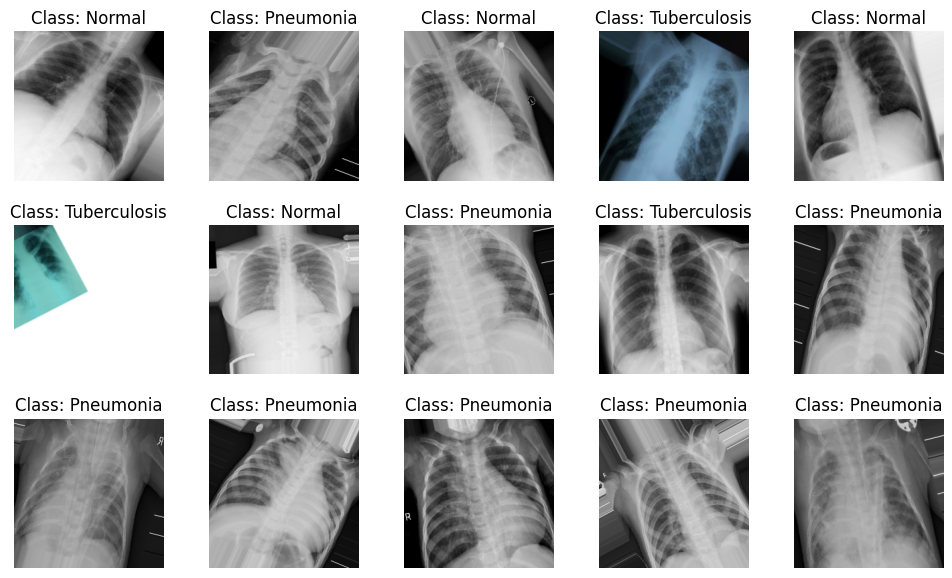

In [8]:
# Get the class indices and names from the train generator
class_indices = train_generator.class_indices
label_to_name = {idx: name for name, idx in class_indices.items()}
samples = train_generator.__next__()  # next fetches the image from the object. Each run gives a new set of images in the training set

images = samples[0]
target = samples[1]

plt.figure(figsize=(12, 12))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])

    # Convert the float target to integer (0 or 1)
    label_idx = tuple(target[i]).index(1)
    class_name = label_to_name[label_idx]

    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.show()

In [9]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%
# class MyCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if logs.get('val_acc') > 0.99:
#             print("\nReached accuracy threshold! Terminating training.")
#             # self.model.stop_training = False

# my_callback = MyCallback()

#Defining a custom callback function to stop training our model when accuracy goes above 99%
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold_count):
        super(MyCallback, self).__init__()
        self.threshold_count = threshold_count
        self.consecutive_count = 0

    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            self.consecutive_count += 1
            if self.consecutive_count >= self.threshold_count:
                print("\nReached accuracy threshold 3 times! Terminating training.")
                self.model.stop_training = True
        else:
            self.consecutive_count = 0

# Define the callback with the threshold count
my_callback = MyCallback(threshold_count=3)

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss",
                                 patience=10)

# EarlyStopping callback to stop training if val_loss does not improve after n epochs
earlystop_cb = EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)

checkpoint_cb = ModelCheckpoint('model.h5', save_best_only=True)

# Inception V3

In [10]:
input_layer=layers.Input(shape=(HEIGHT,WIDTH,CHANNELS))
model_inception=InceptionV3(weights='imagenet',input_tensor=input_layer,include_top=False)
last_layer=model_inception.output
flatten=layers.Flatten()(last_layer) 
output_layer=layers.Dense(n_classes,activation='softmax')(flatten)
model_inception=models.Model(inputs=input_layer,outputs=output_layer)

print("We are making all the layers intrainable except the last layer. \n")
for layer in model_inception.layers[:-1]:
    layer.trainable=False

87910968/87910968 [==============================] - 250s 3us/step
We are making all the layers intrainable except the last layer. 



In [11]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tfa.metrics.F1Score(num_classes=n_classes)]

CALLBACKS = [my_callback, rop_callback, earlystop_cb]

In [12]:
model_inception.compile(optimizer='rmsprop',
                        loss=tf.losses.CategoricalCrossentropy(),
                        metrics=METRICS)
model_inception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                             

 ormalization)                                                                                    
                                                                                                  
 activation_97 (Activation)     (None, 54, 54, 80)   0           ['batch_normalization_97[0][0]'] 
                                                                                                  
 conv2d_98 (Conv2D)             (None, 52, 52, 192)  138240      ['activation_97[0][0]']          
                                                                                                  
 batch_normalization_98 (BatchN  (None, 52, 52, 192)  576        ['conv2d_98[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_98 (Activation)     (None, 52, 52, 192)  0           ['batch_normalization_98[0][0]'] 
          

In [13]:
history_inception = model_inception.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    verbose=True,
    validation_data=valid_generator, 
    callbacks=CALLBACKS, 
    epochs=EPOCHS)

Epoch 1/10
8/8 [==============================] - 11s 633ms/step - loss: 15.0181 - acc: 0.5125 - f1_score: 0.5139 - val_loss: 10.5621 - val_acc: 0.6500 - val_f1_score: 0.5577 - lr: 0.0010
Epoch 2/10
8/8 [==============================] - 4s 496ms/step - loss: 1.2438 - acc: 0.8875 - f1_score: 0.8869 - val_loss: 0.3428 - val_acc: 0.9167 - val_f1_score: 0.9139 - lr: 0.0010
Epoch 3/10
8/8 [==============================] - 4s 479ms/step - loss: 2.0516 - acc: 0.8500 - f1_score: 0.8500 - val_loss: 0.1095 - val_acc: 0.9833 - val_f1_score: 0.9833 - lr: 0.0010
Epoch 4/10
8/8 [==============================] - 4s 471ms/step - loss: 0.7496 - acc: 0.9167 - f1_score: 0.9164 - val_loss: 2.1883 - val_acc: 0.7667 - val_f1_score: 0.7341 - lr: 0.0010
Epoch 5/10
8/8 [==============================] - 4s 478ms/step - loss: 4.8251 - acc: 0.7750 - f1_score: 0.7773 - val_loss: 9.0328 - val_acc: 0.5333 - val_f1_score: 0.4789 - lr: 0.0010
Epoch 6/10
8/8 [==============================] - 4s 468ms/step - loss: 

In [16]:
predictions = model_inception.predict(valid_generator)

# Obtain the true labels from the test_generator
true_labels = valid_generator.classes

# Generate the classification report
report = classification_report(true_labels, predictions.argmax(axis=1), target_names=class_names)
print(report)

600/600 [==============================] - 21s 34ms/step
              precision    recall  f1-score   support

      Normal       0.96      0.90      0.93       200
   Pneumonia       0.94      1.00      0.97       200
Tuberculosis       0.94      0.94      0.94       200

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



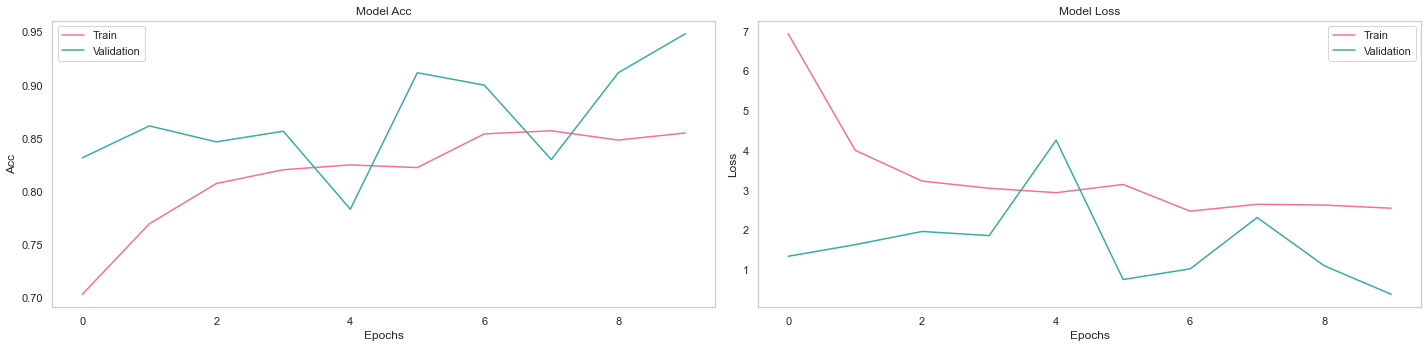

In [17]:
sns.set(style="whitegrid", rc={"axes.grid": False})

# Create a color palette
palette = sns.color_palette("husl", 2)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

# Loop through metrics
for i, metric in enumerate(["acc", "loss"]):
    sns.lineplot(x=history_inception.epoch, y=history_inception.history[metric], ax=ax[i], label="Train", color=palette[0])
    sns.lineplot(x=history_inception.epoch, y=history_inception.history["val_" + metric], ax=ax[i], label="Validation", color=palette[1])

    ax[i].set_title(f"Model {metric.capitalize()}")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric.capitalize())

    ax[i].legend().set_visible(True)

plt.tight_layout()
plt.show()